In [62]:
from src.datamodules.datamodule import DataModule
from src.datamodules.components.datasets import UCFVideoDataset
from src.models.components.core_models import X3D_M

import warnings
warnings.filterwarnings("ignore")

import torch.nn as nn
from torchvision.transforms import Compose
from torchvision.transforms._transforms_video import CenterCropVideo
from pytorchvideo.transforms import Div255, Normalize, ShortSideScale

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]

transform = Compose([Div255(), 
                    Normalize(mean, std), 
                    ShortSideScale(256), 
                    CenterCropVideo([256, 256])])

data = UCFVideoDataset(clip_length_in_frames=16, 
                       step_between_clips=5, 
                       path_to_data="data/explosion/", 
                       path_to_annotation="data/explosion/UCF_train_time_markup.txt",
                       path_to_clips="saves/", video_transform=transform)

In [3]:
datamodule = DataModule(train_dataset=data)
datamodule.setup()

(<torch.utils.data.dataset.Subset at 0x7f1ad25a9e90>,
 <torch.utils.data.dataset.Subset at 0x7f1a4437e550>)

In [192]:
extractor = X3D_M(pretrained=True, block_numbers=1, freezed=True)

Using cache found in /home/cpd/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [224]:
k = 0
for batch, labels in datamodule.val_dataloader():
    if labels.sum().sum() > 0:
        #break
        if k == 2:
            break
        k += 1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a4f949830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a4f949830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

In [225]:
extractor.to("cuda")
batch = batch.to("cuda")

In [226]:
features = extractor(batch.float()).transpose(1, 2)
features = features.flatten(2)

In [227]:
features.shape

torch.Size([16, 16, 393216])

In [228]:
features = features.to("cpu")

In [229]:
labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [237]:
anomaly_video = features[6]
anomaly_labels = labels[6]


normal_video = features[0]
normal_labels = labels[0]

In [238]:
def calculate_emb_dist(video):
    cos = nn.CosineSimilarity()
    l2 = nn.MSELoss()

    cos_dist = []
    l2_dist = []

    for i in range(1, video.shape[0]):
        prev_frame = video[i - 1].unsqueeze(0)
        curr_frame = video[i].unsqueeze(0)

        cos_dist.append(cos(prev_frame, curr_frame).item())  
        l2_dist.append(l2(prev_frame, curr_frame).item())  

    return cos_dist, l2_dist


def calculate_emb_dist_2(video):
    cos = nn.CosineSimilarity()
    l2 = nn.MSELoss()

    cos_dist = []
    l2_dist = []

    for i in range(1, video.shape[0]):
        prev_frame = video[:i].mean(0).unsqueeze(0)
        curr_frame = video[i].unsqueeze(0)

        cos_dist.append(cos(prev_frame, curr_frame).item())  
        l2_dist.append(l2(prev_frame, curr_frame).item())  

    return cos_dist, l2_dist

In [239]:
an_cos, an_l2 = calculate_emb_dist(anomaly_video)
norm_cos, norm_l2 = calculate_emb_dist(normal_video)


In [240]:
ln = nn.LayerNorm(393216)
ln_anom_video = ln(anomaly_video)
ln_an_cos, ln_an_l2 = calculate_emb_dist(ln_anom_video)


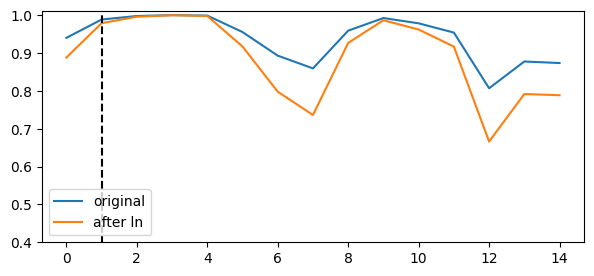

In [241]:
plt.figure(figsize=(7, 3))
plt.plot(an_cos, label='original');
plt.plot(ln_an_cos, label='after ln');
plt.vlines(np.where(anomaly_labels==1)[0][0], 0, 1,  linestyles='dashed', color='black');
plt.ylim(0.4, 1.01);
plt.legend();

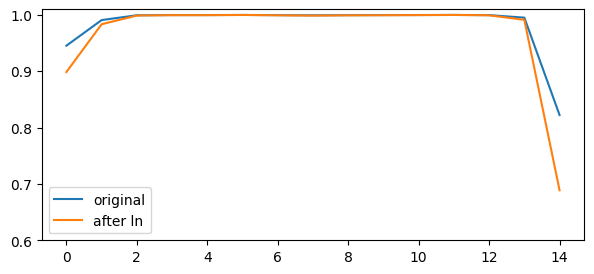

In [236]:
norm_cos, norm_l2 = calculate_emb_dist(normal_video)

ln_norm_video = ln(normal_video)
ln_norm_cos, ln_norm_l2 = calculate_emb_dist(ln_norm_video)

plt.figure(figsize=(7, 3))
plt.plot(norm_cos, label='original');
plt.plot(ln_norm_cos, label='after ln');
plt.ylim(0.6, 1.01);
plt.legend();
